### 0. 라이브러리 설정

In [1]:
from tqdm import tqdm
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',None)
pd.options.display.float_format="{:.5f}".format
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

### 1. 데이터 불러오기

In [2]:
data = pd.read_csv('data/prf_dataset.csv')

In [3]:
data.head(1)

,공연일자,공연시작시간,선예매여부,예매시작일,장르,휴게시간,공연명,내한여부,러닝타임,가격종류,R석,A석,요일,결제내역수,티켓판매량,전체좌석,일반예매율,멤버십합계,가중예매율,멤버십유입률
0,2018-11-25,1700,1,20181029.00000,클래식,15,김대진 피아노 독주회,0,1시간 50분,3,50000.00000,20000.00000,6,1818,1537,2505.00000,0.61357,258,0.00412,0.00671


In [4]:
data.columns

Index(['공연일자', '공연시작시간', '선예매여부', '예매시작일', '장르', '휴게시간', '공연명', '내한여부', '러닝타임',
       '가격종류', 'R석', 'A석', '요일', '결제내역수', '티켓판매량', '전체좌석', '일반예매율', '멤버십합계',
       '가중예매율', '멤버십유입률'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516 entries, 0 to 515
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   공연일자    516 non-null    object 
 1   공연시작시간  516 non-null    int64  
 2   선예매여부   516 non-null    int64  
 3   예매시작일   516 non-null    float64
 4   장르      516 non-null    object 
 5   휴게시간    516 non-null    int64  
 6   공연명     516 non-null    object 
 7   내한여부    516 non-null    int64  
 8   러닝타임    516 non-null    object 
 9   가격종류    516 non-null    int64  
 10  R석      516 non-null    float64
 11  A석      516 non-null    float64
 12  요일      516 non-null    int64  
 13  결제내역수   516 non-null    int64  
 14  티켓판매량   516 non-null    int64  
 15  전체좌석    516 non-null    float64
 16  일반예매율   516 non-null    float64
 17  멤버십합계   516 non-null    int64  
 18  가중예매율   516 non-null    float64
 19  멤버십유입률  516 non-null    float64
dtypes: float64(7), int64(9), object(4)
memory usage: 80.8+ KB


### 2. 데이터 전처리

In [6]:
def make_month(data):
    # 데이터프레임에서 '공연일자' 열을 datetime 형식으로 변환
    result = data.copy()
    result['공연일자'] = pd.to_datetime(result['공연일자'])

    # '월' 열 생성
    result['월'] = result['공연일자'].dt.month
    
    return result

In [7]:
# '러닝타임' column에서 시간과 분을 추출하여 분 단위로 변환
def convert_to_minutes(time_str):
    # '시간'과 '분'을 기준으로 문자열을 분리
    parts = time_str.split()

    total_minutes = 0  # 총 분 초기화

    for part in parts:
        if '시간' in part:
            # '시간'을 포함한 부분에서 숫자를 추출하여 분 단위로 변환
            hours = int(part.replace('시간', '')) * 60
            total_minutes += hours
        elif '분' in part:
            # '분'을 포함한 부분에서 숫자를 추출하여 분 단위로 변환
            minutes = int(part.replace('분', ''))
            total_minutes += minutes

    return total_minutes

In [8]:
def preprocess_new_data(data):
    result = make_month(data)
    
    # '러닝타임' column을 분 단위로 변환하여 새로운 column에 저장
    result['러닝타임'] = result['러닝타임'].apply(convert_to_minutes)
    
    df = result[['공연시작시간', '선예매여부', '장르', '내한여부', '러닝타임', '요일','월']]
        
    return df

In [9]:
# 기존 데이터에 '월' column만 추가
data = make_month(data)

In [10]:
# '장르' encoding 직전의 데이터
df = preprocess_new_data(data)

In [11]:
data.head(1)

,공연일자,공연시작시간,선예매여부,예매시작일,장르,휴게시간,공연명,내한여부,러닝타임,가격종류,R석,A석,요일,결제내역수,티켓판매량,전체좌석,일반예매율,멤버십합계,가중예매율,멤버십유입률,월
0,2018-11-25,1700,1,20181029.00000,클래식,15,김대진 피아노 독주회,0,1시간 50분,3,50000.00000,20000.00000,6,1818,1537,2505.00000,0.61357,258,0.00412,0.00671,11


In [12]:
df.head(1)

,공연시작시간,선예매여부,장르,내한여부,러닝타임,요일,월
0,1700,1,클래식,0,110,6,11


In [13]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

label_encoder.fit(df['장르'])

# '장르' 열에 대한 라벨링 수행
df['장르'] = label_encoder.transform(df['장르'])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

In [14]:
label_mapping

{'교향곡': 0,
 '기타': 1,
 '독주': 2,
 '복합장르': 3,
 '성악': 4,
 '실내악': 5,
 '오페라': 6,
 '재즈': 7,
 '콘서트': 8,
 '크로스오버': 9,
 '클래식': 10,
 '합창': 11}

### 3. Scaling

In [15]:
from sklearn.preprocessing import MinMaxScaler

# 기존 데이터로 스케일러 객체를 학습
scaler = MinMaxScaler()
scaler.fit(df)  # df는 기존 데이터프레임

# 새로운 데이터를 기존 스케일러를 사용하여 변환
scaled_df = pd.DataFrame(data=scaler.transform(df), columns=df.columns)

scaled_df

,공연시작시간,선예매여부,장르,내한여부,러닝타임,요일,월
0,0.70000,1.00000,0.90909,0.00000,0.28571,1.00000,0.90909
1,0.70000,0.00000,0.90909,0.00000,0.50000,0.80000,1.00000
2,1.00000,0.00000,0.72727,1.00000,0.35714,0.40000,1.00000
3,1.00000,1.00000,0.00000,0.00000,0.46429,0.60000,0.09091
4,0.70000,0.00000,0.90909,0.00000,0.35714,0.80000,0.09091
...,...,...,...,...,...,...,...
511,0.70000,1.00000,0.00000,1.00000,0.21429,0.80000,0.54545
512,0.70000,1.00000,0.00000,1.00000,0.35714,1.00000,0.54545
513,0.93000,1.00000,0.00000,0.00000,0.21429,0.00000,0.54545
514,0.93000,1.00000,0.18182,0.00000,0.21429,0.20000,0.54545


### 4. KMeans

In [16]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features):

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=42)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현.
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

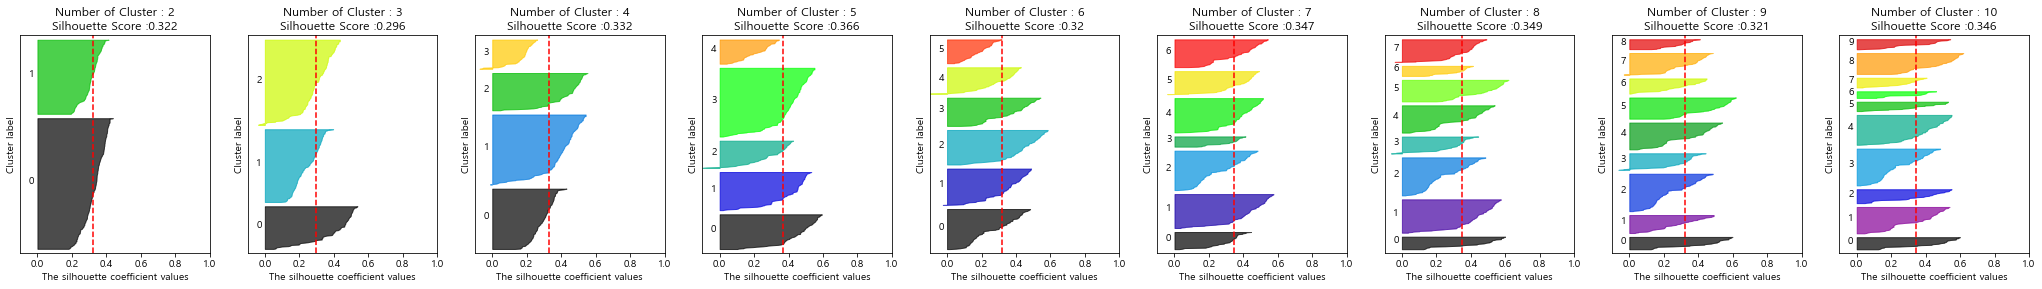

In [17]:
# 실루엣 계수 시각화 -> cluster 개수 6가 최적으로 판단
visualize_silhouette([2,3,4,5,6,7,8,9,10], scaled_df)

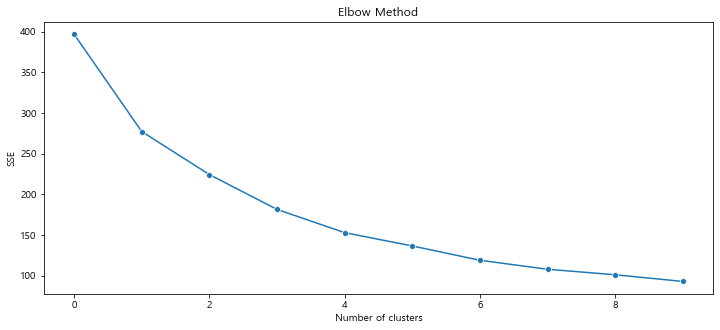

In [18]:
# elbow method 사용
from sklearn.cluster import KMeans
import seaborn as sns

SSE = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, random_state = 42)
    kmeans.fit(scaled_df)
    SSE.append(kmeans.inertia_)

plt.figure(figsize=(12,5))
sns.lineplot(SSE, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [19]:
# KMeans -> n_cluster=6로 진행
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit(scaled_df)

#클러스터링 변수인 clusters 값을 원본 데이터인 'scaled_df'내에 넣기
scaled_df['cluster'] = clusters.labels_
scaled_df.head()

,공연시작시간,선예매여부,장르,내한여부,러닝타임,요일,월,cluster
0,0.70000,1.00000,0.90909,0.00000,0.28571,1.00000,0.90909,1
1,0.70000,0.00000,0.90909,0.00000,0.50000,0.80000,1.00000,4
2,1.00000,0.00000,0.72727,1.00000,0.35714,0.40000,1.00000,4
3,1.00000,1.00000,0.00000,0.00000,0.46429,0.60000,0.09091,0
4,0.70000,0.00000,0.90909,0.00000,0.35714,0.80000,0.09091,4


In [20]:
# cluster를 기준으로 데이터 개수 세기
scaled_df.groupby('cluster').count()

,공연시작시간,선예매여부,장르,내한여부,러닝타임,요일,월
cluster,,,,,,,
0,109,109,109,109,109,109,109
1,99,99,99,99,99,99,99
2,94,94,94,94,94,94,94
3,77,77,77,77,77,77,77
4,72,72,72,72,72,72,72
5,65,65,65,65,65,65,65


In [21]:
#그룹별 특징을 알아보기(그룹별 평균값)
scaled_df.groupby('cluster').mean()

,공연시작시간,선예매여부,장르,내한여부,러닝타임,요일,월
cluster,,,,,,,
0,0.81376,1.00000,0.08257,0.00000,0.32031,0.75963,0.54379
1,0.88212,1.00000,0.92287,0.04040,0.29567,0.39596,0.63361
2,0.90223,0.00000,0.06480,0.00000,0.31421,0.44043,0.49226
3,0.94584,1.00000,0.06612,0.00000,0.30575,0.17143,0.57379
4,0.84792,0.00000,0.88763,0.11111,0.29454,0.56389,0.67803
5,0.80785,0.67692,0.09790,1.00000,0.27000,0.61231,0.53147


In [22]:
# PCA 진행
from sklearn.decomposition import PCA
X = scaled_df.copy()

pca = PCA(n_components=2)

pca.fit(X)
x_pca = pca.transform(X)
x_pca

array([[-1.2447646 , -0.04144244],
       [ 1.83123475, -0.71495578],
       [ 1.97297303, -0.30589627],
       ...,
       [ 0.7438    ,  0.4476549 ],
       [ 0.73936286,  0.3762195 ],
       [ 2.82649879,  0.8379538 ]])

In [23]:
# x_pca를 보기 쉽게 데이터프레임으로 변환
pca_df = pd.DataFrame(x_pca)
pca_df['cluster'] = scaled_df['cluster']
pca_df.head()

,0,1,cluster
0,-1.24476,-0.04144,1
1,1.83123,-0.71496,4
2,1.97297,-0.30590,4
3,-2.22701,0.27262,0
4,1.82787,-0.67928,4


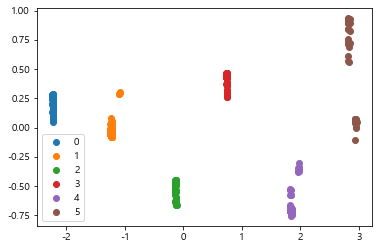

In [24]:
# pca가 완료된 이후의 6개의 cluster 시각화
for i in sorted(pca_df['cluster'].unique()):
    tmp = pca_df.loc[pca_df['cluster'] == i] #해당하는 클러스터 번호일 때 그림을 그리고, for문 실행하며 위에 덧그림
    plt.scatter(tmp[0], tmp[1])
    plt.legend(sorted(pca_df['cluster'].unique()))

In [25]:
scaled_df

,공연시작시간,선예매여부,장르,내한여부,러닝타임,요일,월,cluster
0,0.70000,1.00000,0.90909,0.00000,0.28571,1.00000,0.90909,1
1,0.70000,0.00000,0.90909,0.00000,0.50000,0.80000,1.00000,4
2,1.00000,0.00000,0.72727,1.00000,0.35714,0.40000,1.00000,4
3,1.00000,1.00000,0.00000,0.00000,0.46429,0.60000,0.09091,0
4,0.70000,0.00000,0.90909,0.00000,0.35714,0.80000,0.09091,4
...,...,...,...,...,...,...,...,...
511,0.70000,1.00000,0.00000,1.00000,0.21429,0.80000,0.54545,5
512,0.70000,1.00000,0.00000,1.00000,0.35714,1.00000,0.54545,5
513,0.93000,1.00000,0.00000,0.00000,0.21429,0.00000,0.54545,3
514,0.93000,1.00000,0.18182,0.00000,0.21429,0.20000,0.54545,3


In [26]:
# data에 'cluster' column 추가
data['cluster'] = scaled_df['cluster']
data

,공연일자,공연시작시간,선예매여부,예매시작일,장르,휴게시간,공연명,내한여부,러닝타임,가격종류,R석,A석,요일,결제내역수,티켓판매량,전체좌석,일반예매율,멤버십합계,가중예매율,멤버십유입률,월,cluster
0,2018-11-25,1700,1,20181029.00000,클래식,15,김대진 피아노 독주회,0,1시간 50분,3,50000.00000,20000.00000,6,1818,1537,2505.00000,0.61357,258,0.00412,0.00671,11,1
1,2018-12-08,1700,0,20181029.00000,클래식,20,제175회 국립합창단 정기연주회: 헨델의 메시아,0,2시간 20분,4,50000.00000,10000.00000,5,2463,2165,2505.00000,0.86427,442,0.00706,0.00817,12,4
2,2018-12-20,2000,0,20181110.00000,콘서트,20,파리나무십자가 소년합창단 크리스마스 콘서트 (12.20),1,2시간,4,100000.00000,30000.00000,3,3007,2207,2505.00000,0.88104,0,0.00000,0.00000,12,4
3,2019-02-08,2000,1,20181220.00000,교향곡,15,"대관령겨울음악제 실내악 갈라 콘서트, NOwhere: NOWhere",0,2시간 15분,3,50000.00000,20000.00000,4,1787,1551,2505.00000,0.61916,1494,0.02386,0.03853,2,0
4,2019-02-16,1700,0,20181230.00000,클래식,20,"곤지암 플루트 페스티벌: Hallo, Mozart",0,2시간,4,70000.00000,20000.00000,5,1361,1174,2505.00000,0.46866,1593,0.02544,0.05428,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,2023-07-01,1700,1,20230507.00000,교향곡,15,루돌프 부흐빈더 베토벤 피아노 소나타 전곡 Ⅲ,1,1시간 40분,4,130000.00000,50000.00000,5,4415,2729,2505.00000,1.00000,11123,0.17761,0.16303,7,5
512,2023-07-02,1700,1,20230507.00000,교향곡,15,루체른 심포니,1,2시간,5,260000.00000,70000.00000,6,2821,1941,2505.00000,0.77485,7148,0.11414,0.14731,7,5
513,2023-07-04,1930,1,20230422.00000,교향곡,20,조성진 피아노 리사이틀,0,1시간 40분,4,120000.00000,50000.00000,1,2115,1173,2505.00000,0.46826,11004,0.17571,0.37524,7,3
514,2023-07-05,1930,1,20230410.00000,독주,20,조성진 피아노 리사이틀,0,1시간 40분,4,120000.00000,50000.00000,2,1176,726,2505.00000,0.28982,5501,0.08784,0.30309,7,3


In [27]:
cluster_means = data.groupby('cluster').mean()

In [28]:
'''
요일
(0, '월요일')
(1, '화요일')
(2, '수요일')
(3, '목요일')
(4, '금요일')
(5, '토요일')
(6, '일요일')
'''

"\n요일\n(0, '월요일')\n(1, '화요일')\n(2, '수요일')\n(3, '목요일')\n(4, '금요일')\n(5, '토요일')\n(6, '일요일')\n"

In [29]:
cluster_means

,공연시작시간,선예매여부,예매시작일,휴게시간,내한여부,가격종류,R석,A석,요일,결제내역수,티켓판매량,전체좌석,일반예매율,멤버십합계,가중예매율,멤버십유입률,월
cluster,,,,,,,,,,,,,,,,,
0,1813.76147,1.00000,20211122.00917,15.27523,0.00000,3.68807,89229.35780,26522.93578,4.79817,1377.89908,1022.00917,2254.15596,0.45546,4462.19266,0.08282,0.20309,6.98165
1,1882.12121,1.00000,20207853.08081,14.74747,0.04040,3.58586,81696.96970,25454.54545,2.97980,1601.71717,1315.30303,2412.93939,0.55175,2862.94949,0.04817,0.11499,7.96970
2,1902.23404,0.00000,20211760.67021,13.40426,0.00000,3.75532,89978.72340,26936.17021,3.20213,1413.91489,1133.55319,2380.34043,0.47657,2835.32979,0.04913,0.15844,6.41489
3,1945.84416,1.00000,20211006.14286,15.58442,0.00000,3.42857,76051.94805,25818.18182,1.85714,1534.55844,1216.62338,2437.36364,0.50502,3557.38961,0.05913,0.14245,7.31169
4,1847.91667,0.00000,20205185.70833,13.40278,0.11111,3.68056,98611.11111,29930.55556,3.81944,1440.11111,1204.08333,2468.83333,0.47454,1964.84722,0.03224,0.11135,8.45833
5,1807.84615,0.67692,20213196.09231,13.61538,1.00000,4.21538,150553.84615,43876.92308,4.06154,1877.24615,1406.04615,2505.00000,0.55842,4892.12308,0.07812,0.17629,6.84615


In [30]:
data.to_csv('data/prf_cluster_dataset.csv', index=False)

In [31]:
import joblib

# 모델을 kmeans_model.pkl 파일로 저장
joblib.dump(kmeans, 'data/kmeans_model.pkl')

['data/kmeans_model.pkl']

## 5. 신규 데이터 input

In [32]:
{'교향곡': 0,
 '기타': 1,
 '독주': 2,
 '복합장르': 3,
 '성악': 4,
 '실내악': 5,
 '오페라': 6,
 '재즈': 7,
 '콘서트': 8,
 '크로스오버': 9,
 '클래식': 10,
 '합창': 11}

{'교향곡': 0,
 '기타': 1,
 '독주': 2,
 '복합장르': 3,
 '성악': 4,
 '실내악': 5,
 '오페라': 6,
 '재즈': 7,
 '콘서트': 8,
 '크로스오버': 9,
 '클래식': 10,
 '합창': 11}

In [33]:
'''
요일
(0, '월요일')
(1, '화요일')
(2, '수요일')
(3, '목요일')
(4, '금요일')
(5, '토요일')
(6, '일요일')
'''

"\n요일\n(0, '월요일')\n(1, '화요일')\n(2, '수요일')\n(3, '목요일')\n(4, '금요일')\n(5, '토요일')\n(6, '일요일')\n"

In [34]:
new_data = {'공연일자' : ['2023-10-03','2023-10-19', '2023-11-04', '2023-11-12', '2023-12-01'],
            '공연시작시간': [1700, 1930, 1700, 1700, 2000],
            '선예매여부': [1, 1, 0, 1, 1],
            '예매시작일': [20230719, 20230823, 20230901, 20230906, 20221210],
            '장르': ['클래식', '클래식', '독주','교향곡', '교향곡'],
            '휴게시간': [20, 0, 20, 20, 15],
            '공연명': ['안드라스 쉬프 피아노 리사이틀', '예술의전당 전관 개관 30주년 특별음악회-코리안챔버오케스트라 초청 콘서트', '바리톤 김기훈 리사이틀', '키릴 페트렌코 & 베를린 필하모닉 (11.12)','2023 서울시향 얍 판 츠베덴의 베토벤 삼중 협주곡 ②'],
            '내한여부': [1, 0, 0, 1, 1],
            '러닝타임': ['2시간', '2시간', '1시간 30분', '2시간','1시간 40분'],
            '가격종류': [4, 4, 3, 5, 5],
            'R석': [160000, 80000, 100000, 550000, 100000],
            'A석': [60000, 20000, 60000, 100000, 10000],
            '요일': [1, 3, 5, 6, 4],
            '결제내역수': [0, 0, 0, 0, 0],
            '티켓판매량': [0, 0, 0, 0, 0],
            '전체좌석': [0, 0, 0, 0, 0],
            '일반예매율': [0, 0, 0, 0, 0],
            '멤버십합계': [0, 0, 0, 0, 0],
            '가중예매율': [0, 0, 0, 0, 0],
            '멤버십유입률': [0, 0, 0, 0, 0]
           }

In [35]:
new_data = pd.DataFrame(new_data)

In [36]:
new_data

,공연일자,공연시작시간,선예매여부,예매시작일,장르,휴게시간,공연명,내한여부,러닝타임,가격종류,R석,A석,요일,결제내역수,티켓판매량,전체좌석,일반예매율,멤버십합계,가중예매율,멤버십유입률
0,2023-10-03,1700,1,20230719,클래식,20,안드라스 쉬프 피아노 리사이틀,1,2시간,4,160000,60000,1,0,0,0,0,0,0,0
1,2023-10-19,1930,1,20230823,클래식,0,예술의전당 전관 개관 30주년 특별음악회-코리안챔버오케스트라 초청 콘서트,0,2시간,4,80000,20000,3,0,0,0,0,0,0,0
2,2023-11-04,1700,0,20230901,독주,20,바리톤 김기훈 리사이틀,0,1시간 30분,3,100000,60000,5,0,0,0,0,0,0,0
3,2023-11-12,1700,1,20230906,교향곡,20,키릴 페트렌코 & 베를린 필하모닉 (11.12),1,2시간,5,550000,100000,6,0,0,0,0,0,0,0
4,2023-12-01,2000,1,20221210,교향곡,15,2023 서울시향 얍 판 츠베덴의 베토벤 삼중 협주곡 ②,1,1시간 40분,5,100000,10000,4,0,0,0,0,0,0,0


In [37]:
new_data = make_month(new_data)
df_new = preprocess_new_data(new_data)
df_new['장르'] = label_encoder.transform(df_new['장르'])

In [38]:
scaled_data_new = pd.DataFrame(data=scaler.transform(df_new), columns=df_new.columns)

In [39]:
from sklearn.cluster import KMeans

# 이전에 훈련한 K-Means 모델을 불러오기
kmeans_model = joblib.load('data/kmeans_model.pkl')


# 클러스터 예측
cluster_prediction = kmeans_model.predict(scaled_data_new)

cluster_prediction

array([1, 1, 2, 5, 5])

In [40]:
cluster_means

,공연시작시간,선예매여부,예매시작일,휴게시간,내한여부,가격종류,R석,A석,요일,결제내역수,티켓판매량,전체좌석,일반예매율,멤버십합계,가중예매율,멤버십유입률,월
cluster,,,,,,,,,,,,,,,,,
0,1813.76147,1.00000,20211122.00917,15.27523,0.00000,3.68807,89229.35780,26522.93578,4.79817,1377.89908,1022.00917,2254.15596,0.45546,4462.19266,0.08282,0.20309,6.98165
1,1882.12121,1.00000,20207853.08081,14.74747,0.04040,3.58586,81696.96970,25454.54545,2.97980,1601.71717,1315.30303,2412.93939,0.55175,2862.94949,0.04817,0.11499,7.96970
2,1902.23404,0.00000,20211760.67021,13.40426,0.00000,3.75532,89978.72340,26936.17021,3.20213,1413.91489,1133.55319,2380.34043,0.47657,2835.32979,0.04913,0.15844,6.41489
3,1945.84416,1.00000,20211006.14286,15.58442,0.00000,3.42857,76051.94805,25818.18182,1.85714,1534.55844,1216.62338,2437.36364,0.50502,3557.38961,0.05913,0.14245,7.31169
4,1847.91667,0.00000,20205185.70833,13.40278,0.11111,3.68056,98611.11111,29930.55556,3.81944,1440.11111,1204.08333,2468.83333,0.47454,1964.84722,0.03224,0.11135,8.45833
5,1807.84615,0.67692,20213196.09231,13.61538,1.00000,4.21538,150553.84615,43876.92308,4.06154,1877.24615,1406.04615,2505.00000,0.55842,4892.12308,0.07812,0.17629,6.84615


In [41]:
new_data['cluster'] = cluster_prediction

In [42]:
new_data['cluster_R석'] = 0
new_data['cluster_A석'] = 0

for i in range(len(new_data)):
    cluster_id = new_data.iloc[i]['cluster']
    R = cluster_means.iloc[cluster_id, 6]
    A = cluster_means.iloc[cluster_id, 7]
    new_data.at[i, 'cluster_R석'] = R
    new_data.at[i, 'cluster_A석'] = A

In [43]:
new_data

,공연일자,공연시작시간,선예매여부,예매시작일,장르,휴게시간,공연명,내한여부,러닝타임,가격종류,R석,A석,요일,결제내역수,티켓판매량,전체좌석,일반예매율,멤버십합계,가중예매율,멤버십유입률,월,cluster,cluster_R석,cluster_A석
0,2023-10-03,1700,1,20230719,클래식,20,안드라스 쉬프 피아노 리사이틀,1,2시간,4,160000,60000,1,0,0,0,0,0,0,0,10,1,81696.96970,25454.54545
1,2023-10-19,1930,1,20230823,클래식,0,예술의전당 전관 개관 30주년 특별음악회-코리안챔버오케스트라 초청 콘서트,0,2시간,4,80000,20000,3,0,0,0,0,0,0,0,10,1,81696.96970,25454.54545
2,2023-11-04,1700,0,20230901,독주,20,바리톤 김기훈 리사이틀,0,1시간 30분,3,100000,60000,5,0,0,0,0,0,0,0,11,2,89978.72340,26936.17021
3,2023-11-12,1700,1,20230906,교향곡,20,키릴 페트렌코 & 베를린 필하모닉 (11.12),1,2시간,5,550000,100000,6,0,0,0,0,0,0,0,11,5,150553.84615,43876.92308
4,2023-12-01,2000,1,20221210,교향곡,15,2023 서울시향 얍 판 츠베덴의 베토벤 삼중 협주곡 ②,1,1시간 40분,5,100000,10000,4,0,0,0,0,0,0,0,12,5,150553.84615,43876.92308


In [44]:
new_data.to_csv('data/new_data_cluster.csv', index=False) 